# Anomaly Detection: LOF, Isolation Forest 실습

![1.png](1.png)

![](2.png)

### 1. Import Modules

In [1]:
# !pip install seaborn

import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import scipy.io 
import warnings
warnings.filterwarnings('ignore')

### 2. Import Datasets

![](3.png)

In [2]:
# data link: http://odds.cs.stonybrook.edu/shuttle-dataset/

file = 'shuttle.mat'
mat_file = scipy.io.loadmat(file)

In [3]:
data = pd.DataFrame(mat_file['X'])
data['y']=mat_file['y']
data

,0,1,2,3,4,5,6,7,8,y
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1
...,...,...,...,...,...,...,...,...,...,...
49092,39,-2,80,-4,38,0,41,41,0,0
49093,43,0,81,1,42,-9,37,39,2,0
49094,49,0,87,0,46,-12,38,41,2,0
49095,80,0,84,0,-36,-29,4,120,116,1


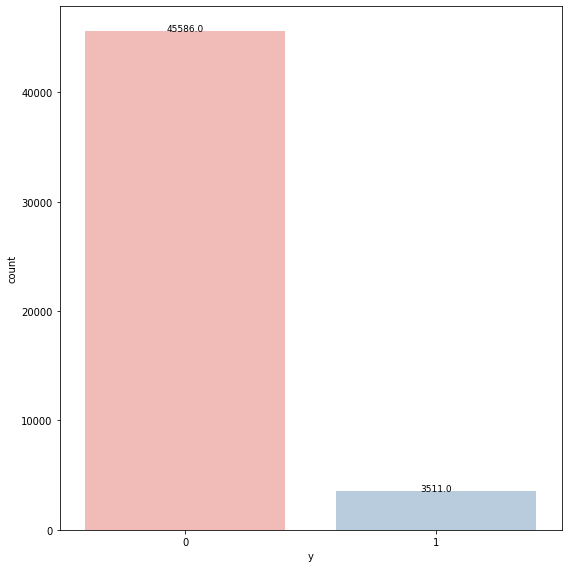

In [4]:
plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax= sns.countplot(x='y', data=data, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

In [5]:
data.to_csv('data_1.csv',index=False)

### 3. LOF (Local Outlier Factor)

#### 3-0. Model Evaluation 

![](4.png)

![](5.png)

![](6.png)

In [6]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def return_result(y_true, y_pred):
    performance = {}
    performance['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    performance['precision_score'] = precision_score(y_true=y_true,y_pred=y_pred)
    performance['recall_score'] = recall_score(y_true=y_true,y_pred=y_pred)
    performance['f1_score'] = f1_score(y_true=y_true,y_pred=y_pred)
    
    return performance

def cf_vis(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Pastel1')
    
    return cf

![](7.jpg)

#### 3-1. LOF From Scratch 

In [7]:
from sklearn.neighbors import NearestNeighbors

def LOF(X, X_test, k):

    knn = NearestNeighbors(n_neighbors=k)

    knn.fit(X)
    
    # Gather the kth nearest neighbor distance
    neighbors_and_distances = knn.kneighbors(X)
    knn_distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    kth_distance = [x[-1] for x in knn_distances] # len(kth_distance)=len(X)
    
    local_reach_density = []
    for i in range(X.shape[0]):
        pt = X[i]
        sum_reachability = 0
        neighbor_distances = knn_distances[i]
        pt_neighbors = neighbors[i]
        for neighbor_distance, neighbor_index in zip(neighbor_distances, pt_neighbors):
            neighbors_kth_distance = kth_distance[neighbor_index]
            sum_reachability = sum_reachability + max([neighbor_distance, neighbors_kth_distance])
            
        avg_reachability = sum_reachability / k
        local_reach_density.append(1/avg_reachability)

    local_reach_density = np.array(local_reach_density) # len(local_reach_density)=len(X)
    lofs = []
    for i in range(X_test.shape[0]):
        pt = X_test[i]
        avg_lrd = np.mean(local_reach_density[neighbors[i]])
        lofs.append(avg_lrd/local_reach_density[i])
        
    return lofs

acc : 0.9076714188730483
precision_score : 0.08174386920980926
recall_score : 0.02849002849002849
f1_score : 0.04225352112676056


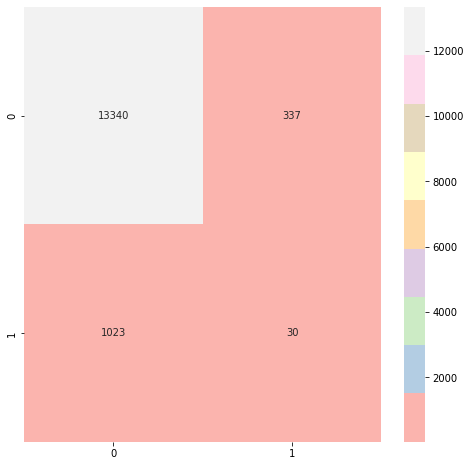

In [8]:
from sklearn.model_selection import train_test_split

def run_LOF(name):
    data = pd.read_csv(name)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        
    lof = LOF(X_train, X_test, 10)
    lof = np.array(lof)
    pred = np.where(lof>=1.5,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)
        
run_LOF('data_1.csv')

#### 3-2. LOF with GridSearch

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best params: {'n_neighbors': 5, 'p': 1}
acc : 0.8826205023761032
precision_score : 0.12938596491228072
recall_score : 0.1120607787274454
f1_score : 0.12010178117048347


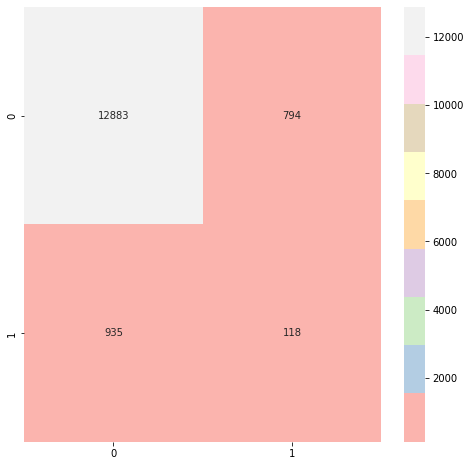

In [9]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

def LOF_Search(name):
    data = pd.read_csv(name)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    model = LocalOutlierFactor()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    

    param_grid = {'n_neighbors': [5, 10, 20], 
                        'p': [1, 2]}
        
    grid_search = GridSearchCV(model,param_grid,scoring="accuracy", refit=True,cv=10, return_train_score=True, verbose=1)

    grid_search.fit(X_train, y_train)
        
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
        
    if_clf = LocalOutlierFactor(**best_params)
    if_clf.fit(X_train, y_train)

    y_pred = if_clf.fit_predict(X_test)
    pred = np.where(y_pred<=-1,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)

LOF_Search('data_1.csv')

#### 4. Isolation Forest

![](8.jpg)

#### 4-1. Isolation Forest From Scratch

In [10]:
import random

def select_feature(data):
    return random.choice(data.columns)

def select_value(data, feat):
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini

def split_data(data, split_column, split_value):
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] > split_value]

    return data_below, data_above

def classify_data(data):

    label_column = data.values[:,]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

In [11]:
def isolation_tree(data, counter=0, max_depth=50):
    if data.empty ==False: 
        # End Loop if max depth or isolated
        if (counter == max_depth) or data.shape[0] == 1:
            classification = classify_data(data)
            return classification
        else:
            # Counter
            counter += 1

            # Select feature
            split_column = select_feature(data)

            # Select value
            split_value = select_value(data, split_column)
            # Split data
            data_below, data_above = split_data(data, split_column, split_value)

            # instantiate sub-tree
            question = "{} <= {}".format(split_column, split_value)
            sub_tree = {question: []}

            # Recursive part
            below_answer = isolation_tree(data_below, counter, max_depth=max_depth)
            above_answer = isolation_tree(data_above, counter, max_depth=max_depth)

            if below_answer == above_answer:
                sub_tree = below_answer
            else:
                sub_tree[question].append(below_answer)
                sub_tree[question].append(above_answer)

        return sub_tree

In [12]:
def isolation_forest(df, n_trees, max_depth, subspace):
    forest = []
    for i in range(n_trees):
        # Sample the subspace
        if subspace <= 1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)
        # Fit tree
        tree = isolation_tree(df, max_depth=max_depth)

        # Save tree to forest
        forest.append(tree)

    return forest

In [13]:
def pathLength(example, iTree, path=0, trace=False):
    # Initialize question and counter
    path = path+1
    question = list(iTree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]

    # base case
    if not isinstance(answer, dict):
        return path

    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree, path=path)

    return path

# Evaluate Distance
def evaluate_instance(instance, forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance, tree))
    return paths

# C_factor
def c_factor(n):
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))


In [14]:
def anomaly_score(data_point, forest, n):

    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point, forest))

    c = c_factor(n)

    return 2**-(E/c)

acc : 0.9778004073319756
precision_score : 0.7770992366412214
recall_score : 0.9667616334283001
f1_score : 0.8616165890816758


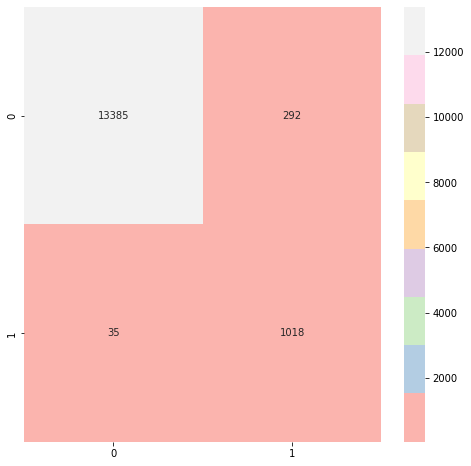

In [15]:
def run_IF(name):
    data = pd.read_csv(name)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        
    iForest = isolation_forest(X_train, n_trees=20, max_depth=100, subspace=256)
    pred = []
    for i in range(X_test.shape[0]):
        pred.append(anomaly_score(X_test.iloc[[i]], iForest, 256))
        
    pred = np.array(pred)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)
        
run_IF('data_1.csv')

#### 4-2. Isolation Forest with GridSearch

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best params: {'max_features': 2, 'n_estimators': 1000}
acc : 0.9654446707399864
precision_score : 0.678477690288714
recall_score : 0.9819563152896487
f1_score : 0.8024835079549865


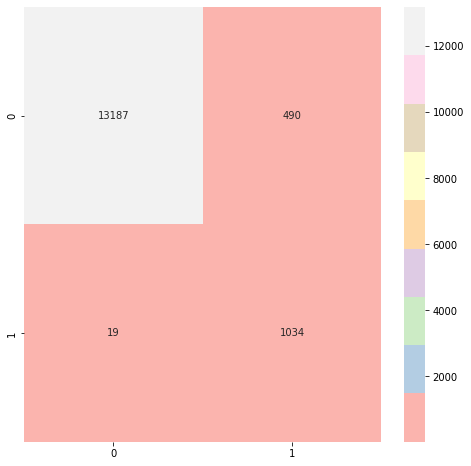

In [16]:
from sklearn.ensemble import IsolationForest

def IF_Search(name):
    data = pd.read_csv(name)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    model = IsolationForest()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    

    param_grid = {'n_estimators': [1000, 1500], 
                    'max_features': [2, 4, 6, 8]}
        
    grid_search = GridSearchCV(model,param_grid, scoring="accuracy", refit=True,cv=10, return_train_score=True, verbose=1)

    grid_search.fit(X_train, y_train)
        
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
        
    if_clf = IsolationForest(**best_params)
    if_clf.fit(X_train, y_train)

    y_pred = if_clf.fit_predict(X_test)
    pred = np.where(y_pred<=-1,1,0)
    
    performance = return_result(y_test, pred)
    
    cf_vis(y_test, pred)

    for k, v in performance.items():
        print(k, ':', v)

IF_Search('data_1.csv')

### EOD